In [2]:
# Appendix B: DC Approximation

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
from pathlib import Path
figures_path = Path().resolve().parent / 'figures'
def generate_colored_noise(alpha, N, dt):
    """
    Generate colored noise with power spectral density S(f) ∝ 1/f^alpha.
    
    Uses spectral method: filter white noise in frequency domain.
    
    Parameters:
    -----------
    alpha : float
        Spectral exponent (1 for 1/f noise, 2 for 1/f^2)
    N : int
        Number of time points
    dt : float
        Time step
        
    Returns:
    --------
    noise : array
        Colored noise time series (zero mean)
    """
    # Generate white noise in frequency domain
    white_noise = np.random.randn(N) + 1j * np.random.randn(N)
    
    # Frequency array
    freqs = np.fft.fftfreq(N, dt)
    
    # Create filter: |f|^(-alpha/2) for power spectral density ∝ 1/f^alpha
    # Avoid division by zero at DC
    filter_func = np.ones(N)
    nonzero = freqs != 0
    filter_func[nonzero] = np.abs(freqs[nonzero])**(-alpha/2)
    
    # Apply low-frequency cutoff to avoid divergence
    f_min = 1.0 / (N * dt)  # Lowest resolvable frequency
    filter_func[np.abs(freqs) < f_min] = filter_func[np.abs(freqs) >= f_min].max()
    
    # Apply filter
    filtered = white_noise * filter_func
    
    # Transform back to time domain
    noise = np.fft.ifft(filtered).real
    
    # Remove mean
    noise = noise - np.mean(noise)
    
    # Normalize to unit variance
    noise = noise / np.std(noise)
    
    return noise

def compute_phase_r12(omega1, omega2, tau, dt_sim, n_experiments=2000):
    """
    Compute the CORRECT r₁₂ from phase correlations in the two-point experiment.
    
    This computes the correlation coefficient between:
    - φ₁ = ∫₀^(τ/2) ω₁(t) dt
    - φ₂ = ∫_(τ/2)^τ ω₂(t) dt
    
    This is what actually enters the DC approximation formula!
    """
    n_half = int(tau / (2 * dt_sim))
    
    if n_half < 2:
        return np.nan
    
    phi1_list = []
    phi2_list = []
    for _ in range(n_experiments):
        start_idx = np.random.randint(0, len(omega1) - 2*n_half - 100)
        
        # Phase at position 1 (time [0, tau/2])
        phi_1 = np.trapz(omega1[start_idx:start_idx + n_half], dx=dt_sim)
        
        # Phase at position 2 (time [tau/2, tau])  
        phi_2 = np.trapz(omega2[start_idx + n_half:start_idx + 2*n_half], dx=dt_sim)
        
        phi1_list.append(phi_1)
        phi2_list.append(phi_2)
  
    # Compute correlation coefficient between phases
    return np.corrcoef(phi1_list, phi2_list)[0, 1]

def compute_decoherence_chi(omega, tau_values):
    """
    Compute decoherence function chi for different tau values.
    
    chi = (1/2) * <phi^2> where phi = integral of omega(t) dt over [0, tau/2]
    
    Parameters:
    -----------
    omega : array
        Noise trajectory
    tau_values : array
        Evolution times to compute chi for
        
    Returns:
    --------
    chi : array
        Decoherence function values
    """
    dt_sim = tau_values[1] - tau_values[0]
    chi = np.zeros(len(tau_values))
    
    for i, tau in enumerate(tau_values):
        # Number of steps in tau/2
        n_half = int(tau / (2 * dt_sim))
        if n_half < 2:
            continue
            
        # Simulate many Ramsey experiments
        n_experiments = 1000
        phi_squared = []
        
        for _ in range(n_experiments):
            # Random starting point (avoiding edges)
            start_idx = np.random.randint(0, len(omega) - 2*n_half - 100)
            
            # Integrate over [0, tau/2]
            phi = np.trapz(omega[start_idx:start_idx + n_half], dx=dt_sim)
            phi_squared.append(phi**2)
        
        chi[i] = 0.5 * np.mean(phi_squared)
    
    return chi

def compute_twopoint_decoherence_chi(omega1, omega2, tau_values, Delta_t=0):
    """
    Compute two-point decoherence function.
    
    Protocol: evolve at position 1 for tau/2, shuttle (time Delta_t), 
    evolve at position 2 for tau/2
    
    Parameters:
    -----------
    omega1, omega2 : arrays
        Noise trajectories at positions 1 and 2
    tau_values : array
        Evolution times
    Delta_t : float
        Shuttling time (we assume no decoherence during shuttling)
        
    Returns:
    --------
    chi : array
        Two-point decoherence function
    """
    dt_sim = tau_values[1] - tau_values[0]
    chi = np.zeros(len(tau_values))
    
    for i, tau in enumerate(tau_values):
        n_half = int(tau / (2 * dt_sim))
        n_shuttle = int(Delta_t / dt_sim)
        
        if n_half < 2:
            continue
        
        n_experiments = 1000
        phi_squared = []
        
        for _ in range(n_experiments):
            # Random starting point
            start_idx = np.random.randint(0, len(omega1) - 2*n_half - n_shuttle - 100)
            
            # Phase from position 1 (time [0, tau/2])
            phi_1 = np.trapz(omega1[start_idx:start_idx + n_half], dx=dt_sim)
            
            # Phase from position 2 (time [tau/2 + Delta_t, tau + Delta_t])
            start_idx_2 = start_idx + n_half + n_shuttle
            phi_2 = np.trapz(omega2[start_idx_2:start_idx_2 + n_half], dx=dt_sim)
            
            # Total phase
            phi_total = phi_1 + phi_2
            phi_squared.append(phi_total**2)
        
        chi[i] = 0.5 * np.mean(phi_squared)
    
    return chi


In [3]:
# Systematic test with simplified model
n_tests_simple = 100
N_simple = 50000  # Long trajectory
dt_simple = 0.001
t_simple = np.arange(N_simple) * dt_simple

# Tau range for DC regime
tau_simple = np.logspace(-1, 1, 20)  # 0.1 to ~3

results_simple = {
    'r12_true': [],        # From coupling matrix (instantaneous)
    'r12_phase': [],       # From phase correlation (correct for DC)
    'r12_fitted': [],      # From decoherence fit
    'alpha_1': [],         # First noise source exponent
    'alpha_2': [],         # Second noise source exponent
    'alpha_min': [],       # min(α₁, α₂)
    'alpha_diff': [],      # |α₁ - α₂|
    'T2_1': [],            # Fitted T2 at position 1
    'T2_2': []             # Fitted T2 at position 2
}

np.random.seed(42)
print(f"Running {n_tests_simple} tests with simplified 2-source model...")
print("Progress: ", end='', flush=True)

for i in range(n_tests_simple):
    if (i+1) % 10 == 0:
        print(f"{i+1}...", end='', flush=True)
    
    # Random α values between 0.5 and 2
    alpha_1 = 1+ 1 * np.random.rand()  # [0.5, 2.0]
    alpha_2 = 1 + 1 * np.random.rand()  # [0.5, 2.0]
    
    # Generate two independent colored noise sources
    xi_1 = generate_colored_noise(alpha_1, N_simple, dt_simple)
    xi_2 = generate_colored_noise(alpha_2, N_simple, dt_simple)
    
    # Scale noise to achieve approximately constant T2
    # For 1/f^alpha noise integrated over time tau, the phase variance grows as:
    # Var(phi) ~ integral of S(f)/f^2 ~ tau^alpha for low frequencies
    # Since chi ~ (tau/T2)^alpha, to keep T2 constant we scale noise by alpha^(1/2)
    scale_1 = alpha_1**(0.5)
    scale_2 = alpha_2**(0.5)
    
    xi_1 = xi_1 / scale_1
    xi_2 = xi_2 / scale_2
    
    # Random coupling matrix (entries between -1 and 1)
    V = 2 * np.random.rand(2, 2) - 1  # Uniform in [-1, 1]
    
    # Noise at two positions
    omega_1 = V[0, 0] * xi_1 + V[0, 1] * xi_2
    omega_2 = V[1, 0] * xi_1 + V[1, 1] * xi_2
    
    # r12_true: from coupling matrix (instantaneous correlation)
    # Correlation of omega_1 and omega_2 from independent sources
    # Cov(omega_1, omega_2) = V[0,0]*V[1,0]*Var(xi_1) + V[0,1]*V[1,1]*Var(xi_2)
    # Since Var(xi_i) = 1 (normalized), and xi_1, xi_2 independent:
    r12_true = (V[0,0]*V[1,0] + V[0,1]*V[1,1]) / np.sqrt(V[0,0]**2 + V[0,1]**2) / np.sqrt(V[1,0]**2 + V[1,1]**2)
    
    # r12_phase: from phase correlation at typical τ
    tau_mid = tau_simple[len(tau_simple)//2]
    r12_phase = compute_phase_r12(omega_1, omega_2, tau_mid, dt_simple, n_experiments=1000)
    
    # Compute decoherence
    chi_1_s = compute_decoherence_chi(omega_1, tau_simple)
    chi_2_s = compute_decoherence_chi(omega_2, tau_simple)
    chi_12_s = compute_twopoint_decoherence_chi(omega_1, omega_2, tau_simple, Delta_t=1e-3)
    
    # Fit and extract r12
    try:
        def powerlaw(tau, T2star, alpha):
            return (tau / (2 * T2star))**alpha
        
        popt_1, _ = curve_fit(powerlaw, tau_simple, chi_1_s, p0=[1.0, 1.5], 
                              bounds=([0.01, 0.5], [100, 3.0]), maxfev=5000)
        popt_2, _ = curve_fit(powerlaw, tau_simple, chi_2_s, p0=[1.0, 1.5], 
                              bounds=([0.01, 0.5], [100, 3.0]), maxfev=5000)
        
        T2_1_s, alpha_1_fit = popt_1
        T2_2_s, alpha_2_fit = popt_2
        
        def chi_DC_model(tau, r12):
            chi_n = (tau / (2 * T2_1_s))**alpha_1_fit
            chi_m = (tau / (2 * T2_2_s))**alpha_2_fit
            return chi_n + chi_m + 2 * r12 * np.sqrt(chi_n * chi_m)
        
        popt_r12, _ = curve_fit(chi_DC_model, tau_simple, chi_12_s, p0=[0.5], 
                                bounds=([-1], [1]), maxfev=5000)
        r12_fitted = popt_r12[0]
        
        # Store results
        if not np.isnan(r12_phase) and not np.isnan(r12_fitted):
            results_simple['r12_true'].append(r12_true)
            results_simple['r12_phase'].append(r12_phase)
            results_simple['r12_fitted'].append(r12_fitted)
            results_simple['alpha_1'].append(alpha_1)
            results_simple['alpha_2'].append(alpha_2)
            results_simple['alpha_min'].append(min(alpha_1, alpha_2))
            results_simple['alpha_diff'].append(abs(alpha_1 - alpha_2))
            results_simple['T2_1'].append(T2_1_s)
            results_simple['T2_2'].append(T2_2_s)
    except Exception as e:
        pass

# Convert to arrays
for key in results_simple:
    results_simple[key] = np.array(results_simple[key])

print(f"\n✓ Completed {len(results_simple['r12_true'])} successful fits out of {n_tests_simple} attempts")


Running 100 tests with simplified 2-source model...
Progress: 

10...20...30...40...50...60...70...80...90...100...
✓ Completed 100 successful fits out of 100 attempts


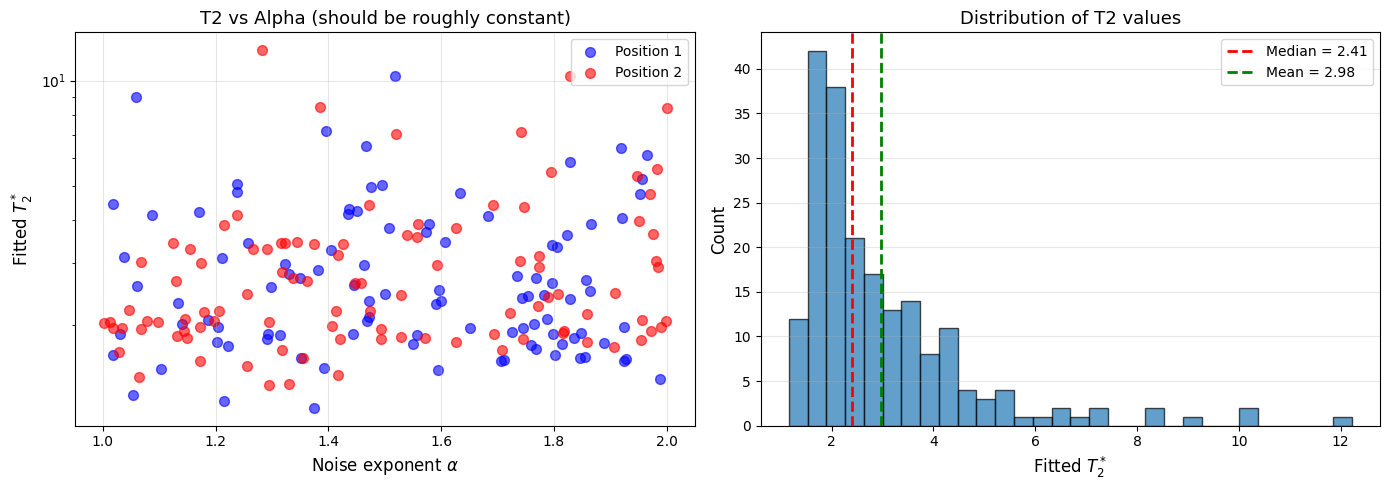


T2 STATISTICS:
T2 range: 1.160 to 12.221
T2 mean: 2.977 ± 1.725
T2 median: 2.409
T2 coefficient of variation: 0.579

Alpha range: 1.001 to 2.000


In [7]:
# Removed: diagnostic plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot T2 vs alpha for both positions
ax = axes[0]
ax.scatter(results_simple['alpha_1'], results_simple['T2_1'], 
           alpha=0.6, s=50, label='Position 1', color='blue')
ax.scatter(results_simple['alpha_2'], results_simple['T2_2'], 
           alpha=0.6, s=50, label='Position 2', color='red')
ax.set_xlabel(r'Noise exponent $\alpha$', fontsize=12)
ax.set_ylabel(r'Fitted $T_2^*$', fontsize=12)
ax.set_title('T2 vs Alpha (should be roughly constant)', fontsize=13)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# Plot histogram of T2 values
ax = axes[1]
T2_all = np.concatenate([results_simple['T2_1'], results_simple['T2_2']])
ax.hist(T2_all, bins=30, alpha=0.7, edgecolor='black')
ax.axvline(np.median(T2_all), color='red', linestyle='--', linewidth=2, 
           label=f'Median = {np.median(T2_all):.2f}')
ax.axvline(np.mean(T2_all), color='green', linestyle='--', linewidth=2, 
           label=f'Mean = {np.mean(T2_all):.2f}')
ax.set_xlabel(r'Fitted $T_2^*$', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distribution of T2 values', fontsize=13)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n{'='*70}")
print("T2 STATISTICS:")
print(f"{'='*70}")
print(f"T2 range: {np.min(T2_all):.3f} to {np.max(T2_all):.3f}")
print(f"T2 mean: {np.mean(T2_all):.3f} ± {np.std(T2_all):.3f}")
print(f"T2 median: {np.median(T2_all):.3f}")
print(f"T2 coefficient of variation: {np.std(T2_all)/np.mean(T2_all):.3f}")
print(f"\nAlpha range: {np.min([results_simple['alpha_1'].min(), results_simple['alpha_2'].min()]):.3f} to {np.max([results_simple['alpha_1'].max(), results_simple['alpha_2'].max()]):.3f}")


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.



SIMPLIFIED MODEL RESULTS:

Fitted vs Noise correlation (from v vectors):
  Mean error:     -0.007199
  Std error:      0.154003
  RMSE:           0.154171
  Correlation:    0.9755

Fitted vs Phase correlation:
  Mean error:     +0.016655
  Std error:      0.095787
  RMSE:           0.097224
  Correlation:    0.9907

Noise correlation vs Phase correlation:
  Mean difference: +0.023853
  Std difference:  0.200513
  Correlation:     0.9617

NOTE: The DC approximation extracts r_AB that matches the PHASE correlation,
      not the instantaneous noise correlation. This is expected because
      the dephasing depends on integrated phases φ = ∫ξ(t)dt, not ξ(t) itself.


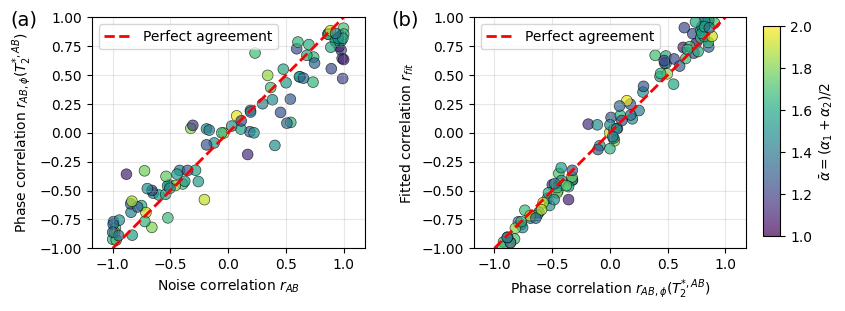

In [9]:


alpha_avg = (results_simple['alpha_1'] + results_simple['alpha_2']) / 2

# Main scatter plots: r12_true vs r12_fitted, and r12_phase vs r12_fitted
# Use GridSpec to maintain equal plot widths, colorbar outside
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(8.5, 3))
# Reserve space on the right for colorbar (leaving ~15% of width)
fig.subplots_adjust(right=0.85)
gs = GridSpec(1, 2, figure=fig, width_ratios=[1, 1], wspace=0.4, 
              left=0.08, right=0.85)

# Plot 3: r12_true vs r12_phase
ax3 = fig.add_subplot(gs[0, 0])
scatter3 = ax3.scatter(results_simple['r12_true'], results_simple['r12_phase'], 
                      c=alpha_avg, s=60, alpha=0.7, 
                      cmap='viridis', edgecolors='black', linewidth=0.5,
                      vmin=1.0, vmax=2.0)
ax3.plot([-1, 1], [-1, 1], 'r--', linewidth=2, label='Perfect agreement')
ax3.set_xlabel(r'Noise correlation $r_{AB}$')
ax3.set_ylabel(r'Phase correlation $r_{AB,\phi}(T_{2}^{*,AB})$')
ax3.grid(True, alpha=0.3)
ax3.axis('equal')
ax3.set_xlim([-1, 1])
ax3.set_ylim([-1, 1])
ax3.legend(fontsize=10)

# Plot 2: r12_phase vs r12_fitted, colored by average α
ax2 = fig.add_subplot(gs[0, 1])
scatter2 = ax2.scatter(results_simple['r12_phase'], results_simple['r12_fitted'],
                      c=alpha_avg, s=60, alpha=0.7, 
                      cmap='viridis', edgecolors='black', linewidth=0.5,
                      vmin=1.0, vmax=2.0)
ax2.plot([-1, 1], [-1, 1], 'r--', linewidth=2, label='Perfect agreement')
ax2.set_ylabel(r'Fitted correlation $r_{fit}$')
ax2.set_xlabel(r'Phase correlation $r_{AB, \phi}(T_{2}^{*,AB})$')
ax2.grid(True, alpha=0.3)
ax2.axis('equal')
ax2.set_ylim([-1, 1])
ax2.set_xlim(-1, 1)
ax2.legend(fontsize=10)

# Add colorbar outside the GridSpec area on the right
cax = fig.add_axes([0.87, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = plt.colorbar(scatter3, cax=cax)
cbar.set_label(r'$\bar{\alpha} = (\alpha_1 + \alpha_2)/2$')

# Add subplot annotation "a)" and "b)"
ax3.annotate('(a)', xy=(-0.3, 0.95), xycoords='axes fraction', fontsize=14, ha='left', va='bottom')
ax2.annotate('(b)', xy=(-.3, 0.95), xycoords='axes fraction', fontsize=14, ha='left', va='bottom')


# Statistics
error_true = results_simple['r12_fitted'] - results_simple['r12_true']
error_phase = results_simple['r12_fitted'] - results_simple['r12_phase']
error_true_phase = results_simple['r12_true'] - results_simple['r12_phase']

print(f"\n{'='*70}")
print("SIMPLIFIED MODEL RESULTS:")
print(f"{'='*70}")
print(f"\nFitted vs Noise correlation (from v vectors):")
print(f"  Mean error:     {np.mean(error_true):+.6f}")
print(f"  Std error:      {np.std(error_true):.6f}")
print(f"  RMSE:           {np.sqrt(np.mean(error_true**2)):.6f}")
print(f"  Correlation:    {np.corrcoef(results_simple['r12_fitted'], results_simple['r12_true'])[0,1]:.4f}")

print(f"\nFitted vs Phase correlation:")
print(f"  Mean error:     {np.mean(error_phase):+.6f}")
print(f"  Std error:      {np.std(error_phase):.6f}")
print(f"  RMSE:           {np.sqrt(np.mean(error_phase**2)):.6f}")
print(f"  Correlation:    {np.corrcoef(results_simple['r12_fitted'], results_simple['r12_phase'])[0,1]:.4f}")

print(f"\nNoise correlation vs Phase correlation:")
print(f"  Mean difference: {np.mean(error_true_phase):+.6f}")
print(f"  Std difference:  {np.std(error_true_phase):.6f}")
print(f"  Correlation:     {np.corrcoef(results_simple['r12_true'], results_simple['r12_phase'])[0,1]:.4f}")

print(f"\n{'='*70}")
print("NOTE: The DC approximation extracts r_AB that matches the PHASE correlation,")
print("      not the instantaneous noise correlation. This is expected because")
print("      the dephasing depends on integrated phases φ = ∫ξ(t)dt, not ξ(t) itself.")
print(f"{'='*70}")

plt.savefig(f'{figures_path}/app_fig7_r12DC.pdf', dpi=300, bbox_inches='tight')

/var/folders/wj/x78z9z710q7csr068fhd10bxk7mx3x/T/ipykernel_68571/3599599519.py:77: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_boxes, labels=labels, patch_artist=True)
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


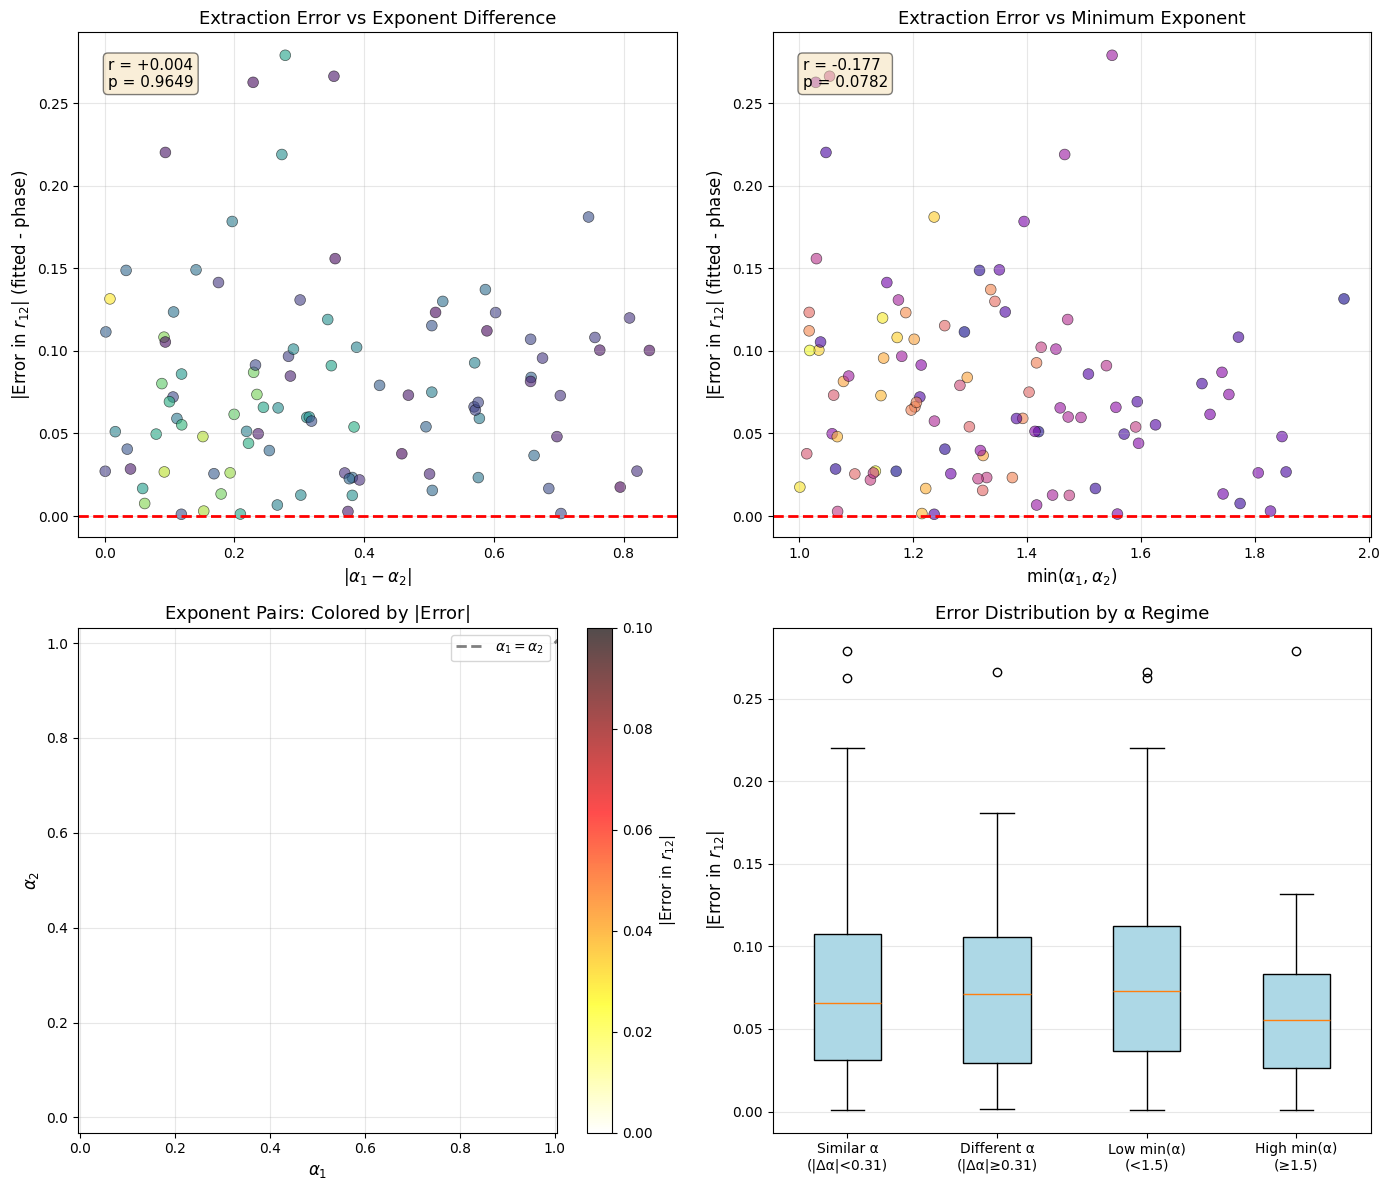


INFLUENCE OF α PARAMETERS:

Correlations with |Error| (fitted - phase):
  |α₁ - α₂|:       r = +0.004, p = 0.9649
  min(α₁, α₂):    r = -0.177, p = 0.0782

Error statistics by regime:
  Similar α (|Δα|<0.31)              : 0.08060 ± 0.06520
  Different α (|Δα|≥0.31)            : 0.07499 ± 0.05035
  Low min(α) (<1.5)                  : 0.08182 ± 0.05813
  High min(α) (≥1.5)                 : 0.06432 ± 0.05688


In [6]:
# Removed: detailed analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Error vs |α₁ - α₂|
ax = axes[0, 0]
ax.scatter(results_simple['alpha_diff'], np.abs(error_phase), 
           c=results_simple['alpha_min'], s=60, alpha=0.6, 
           cmap='viridis', edgecolors='black', linewidth=0.5)
ax.axhline(0, color='red', linestyle='--', linewidth=2)
ax.set_xlabel(r'$|\alpha_1 - \alpha_2|$', fontsize=12)
ax.set_ylabel(r'$|$Error in $r_{12}|$ (fitted - phase)', fontsize=12)
ax.set_title(r'Extraction Error vs Exponent Difference', fontsize=13)
ax.grid(True, alpha=0.3)

# Correlation
from scipy.stats import pearsonr
corr_diff, p_diff = pearsonr(results_simple['alpha_diff'], np.abs(error_phase))
ax.text(0.05, 0.95, f'r = {corr_diff:+.3f}\np = {p_diff:.4f}', 
        transform=ax.transAxes, fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: Error vs min(α)
ax = axes[0, 1]
ax.scatter(results_simple['alpha_min'], np.abs(error_phase), 
           c=results_simple['alpha_diff'], s=60, alpha=0.6, 
           cmap='plasma', edgecolors='black', linewidth=0.5)
ax.axhline(0, color='red', linestyle='--', linewidth=2)
ax.set_xlabel(r'$\min(\alpha_1, \alpha_2)$', fontsize=12)
ax.set_ylabel(r'$|$Error in $r_{12}|$ (fitted - phase)', fontsize=12)
ax.set_title(r'Extraction Error vs Minimum Exponent', fontsize=13)
ax.grid(True, alpha=0.3)

corr_min, p_min = pearsonr(results_simple['alpha_min'], np.abs(error_phase))
ax.text(0.05, 0.95, f'r = {corr_min:+.3f}\np = {p_min:.4f}', 
        transform=ax.transAxes, fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 3: α₁ vs α₂, colored by |error|
ax = axes[1, 0]
scatter3 = ax.scatter(results_simple['alpha_1'], results_simple['alpha_2'], 
                      c=np.abs(error_phase), s=100, alpha=0.7, 
                      cmap='hot_r', edgecolors='black', linewidth=0.5,
                      vmin=0, vmax=0.1)
ax.plot([1, 2], [1, 2], 'k--', linewidth=2, alpha=0.5, label=r'$\alpha_1 = \alpha_2$')
ax.set_xlabel(r'$\alpha_1$', fontsize=12)
ax.set_ylabel(r'$\alpha_2$', fontsize=12)
ax.set_title(r'Exponent Pairs: Colored by $|$Error$|$', fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.axis('equal')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
cbar3 = plt.colorbar(scatter3, ax=ax)
cbar3.set_label(r'$|$Error in $r_{12}|$', fontsize=11)

# Plot 4: Distribution of errors by α regime
ax = axes[1, 1]

# Define regimes
similar_alpha = results_simple['alpha_diff'] < np.median(results_simple['alpha_diff'])
low_alpha = results_simple['alpha_min'] < 1.5

labels = [
    f'Similar α\n(|Δα|<{np.median(results_simple["alpha_diff"]):.2f})',
    f'Different α\n(|Δα|≥{np.median(results_simple["alpha_diff"]):.2f})',
    f'Low min(α)\n(<1.5)',
    f'High min(α)\n(≥1.5)'
]

data_boxes = [
    np.abs(error_phase[similar_alpha]),
    np.abs(error_phase[~similar_alpha]),
    np.abs(error_phase[low_alpha]),
    np.abs(error_phase[~low_alpha])
]

bp = ax.boxplot(data_boxes, labels=labels, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')

ax.set_ylabel(r'$|$Error in $r_{12}|$', fontsize=12)
ax.set_title('Error Distribution by α Regime', fontsize=13)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print regime statistics
print(f"\n{'='*70}")
print("INFLUENCE OF α PARAMETERS:")
print(f"{'='*70}")
print(f"\nCorrelations with |Error| (fitted - phase):")
print(f"  |α₁ - α₂|:       r = {corr_diff:+.3f}, p = {p_diff:.4f}")
print(f"  min(α₁, α₂):    r = {corr_min:+.3f}, p = {p_min:.4f}")

print(f"\nError statistics by regime:")
for i, label in enumerate(labels):
    data = data_boxes[i]
    print(f"  {label.replace(chr(10), ' '):35s}: {np.mean(data):.5f} ± {np.std(data):.5f}")
